In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt 

from pymongo import MongoClient

In [2]:
# for vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer

#preprocessing
from sklearn.preprocessing import Normalizer

In [3]:
import datetime as dt 

start = dt.datetime.now()
#print ('test')

print "the loading took {} seconds ".format((dt.datetime.now()-start).seconds)

the loading took 0 seconds 


In [4]:
# connect to nytime database

client = MongoClient()

db = client.nyt
nyt_fulltext = db.nyt_fulltext

nyt_data = db.nyt_data

### billie's pipeline

1. Read in data from MongodDB 
2. extract text from each article
3. text needs to remove stop words, commas, 
    1. use tfidf here, it will do this for you
4. get vectors for the document
5. np.mean() for the vectors, get one mean vector for document
6. take cosine similarity with reference document
7. pick N top choices for Recommendations

In [5]:
nyt_fulltext.count()

12952

### Step 1: extract text

In [6]:
''' retrieve full corpus'''
test = list(db.nyt_fulltext.find({},{"article": 1,
                                    "query": 1,
                                    "headline": 1,
                                      "date" : 1
   }) )
# consider also "snippet" :1
# later do whole text

In [7]:
df = pd.DataFrame(test, columns=["query", 'article', 'headline', 'date'] )
df[:3]

,query,article,headline,date
0,economics,"BIDDEFORD, Me. When Kylie Galliani started at...","With Free Bikes, Challenging Car Culture on Ca...",2008-10-20
1,economics,"In the video below, CNBC reports anew on New Y...",Wind Turbines in New York?,2008-10-20
2,economics,Is Europe no longer an economic museum? In rec...,"Suddenly, Europe Looks Pretty Smart",2008-10-20


In [13]:
# business 370, economics 2899, sports 2728, music 4277,1000 , politics 1570
# music = 4303, economics 980, sports 2715, tech 990            # politics 950
df[df['query']=='music'].count()

query       2151
article     2117
headline    2151
date        2151
dtype: int64

In [9]:
#Use the first 6 months
df = df[(df['date'] > '2016-01-01') & (df['date'] < '2016-10-31')]

In [10]:
df.shape

(10296, 4)

#### rows dropped + and drop null titles + Duplicates 
- music: every 3rd then every 2nd  1434
- sports: every 2nd row: 1357

In [11]:
## drop music and sports rows
df.drop( df[df['query']=='music'][::2].index, axis=0, inplace=True)
df.drop( df[df['query']=='sports'][::2].index, axis=0, inplace=True)

In [14]:
df[df['query']=='politics'].count()

query       964
article     956
headline    964
date        964
dtype: int64

In [15]:
df[df['query']=='music'].count()

query       2151
article     2117
headline    2151
date        2151
dtype: int64

In [16]:
#df.drop( df[df['query']=='sports'][::2].index, axis=0, inplace=True)
df[df['query']=='sports'].count()

query       1357
article     1349
headline    1357
date        1357
dtype: int64

In [17]:
df['query'].unique()

array([u'economics', u'politics', u'tech', u'business', u'sports', u'music'], dtype=object)

In [18]:
df.dropna(axis=0,inplace=True)

In [19]:
df[df.article.isnull()].count()

query       0
article     0
headline    0
date        0
dtype: int64

In [20]:
df.drop_duplicates(subset=['headline'], inplace=True)

In [21]:
df.shape

(6203, 4)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6203 entries, 927 to 12948
Data columns (total 4 columns):
query       6203 non-null object
article     6203 non-null object
headline    6203 non-null object
date        6203 non-null object
dtypes: object(4)
memory usage: 242.3+ KB


In [23]:
df['query'].unique()

array([u'economics', u'politics', u'tech', u'business', u'sports', u'music'], dtype=object)

# step 2: preprocessing of the text
= try 2-grams

In [24]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']
stop += ['would','one','like', 'mr','ms','also','could','said','should',
     'first', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight'
    , 'nine', 'ten', 'mrs', 'years','last', 'im' ,'dont','street', 'think',
        'time', 'many', 'even', 'sanderss', 'york', 'new', 'companies', 'trumps'
        , 'donald', 'bernie','apples', 'de', 'com', 'year',
        'percent', 'much', 'cruzs', 'clintons', 'care', 'rose','org',
        'make', 'ted', 'dr', 'start','union','news','program','banks', 'central',
        'chinas','greeces', 'greek', 'big' ]

stop[-5:]

['central', 'chinas', 'greeces', 'greek', 'big']

In [25]:
#tfidf = TfidfVectorizer(stop, min_df=5, ngram_range=(1,1) )
## token pattern should get rid off  the numbers

CountVectorizer
tfidf = TfidfVectorizer(stop_words=stop,min_df=20, token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                        # lowercase=True, # default
                        ngram_range=(1,2) )

In [26]:
tfidf_vecs = tfidf.fit_transform(df.article)
#tfidf_vecs = tfidf.fit_transform(df_smaller.article)

In [27]:
X = pd.DataFrame(tfidf_vecs.todense(),
             columns=tfidf.get_feature_names())
X[:3]

,aaa,aaron,abandon,abandoned,abandoning,abbey,abbott,abc,abcs,abdul,...,zip,zoe,zombies,zone,zone discovering,zones,zoning,zoo,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


+ stop words (modified)
- **min_df=20,  ngram_range=(1,2),  >20,000 columns **

Can also do Count Vectorizer (how many words I have in doc)
### play with Vectorizer methods

In [29]:
#tfidf_vecs.check_format
#tfidf.analyzer
###''' i do this later anyway'''
# features = list(tfidf.get_feature_names())
# features[:5000:500]

### LSA :   Dimension Reduction / Feature Extraction
- tall skinny + short wide matrices
#### Number of topics
+ 50
+ try 20/15

In [30]:
'''
pass the raw tfidf_vecs (not the dataframe to the LSA fransform )
first param = Desired dimensionality of output data. Must be strictly less than the number of features. 
The default value is useful for visualisation. For LSA, a value of 100 is recommended


try: 20 topics
'''

lsa = TruncatedSVD(20, algorithm = 'arpack')
reduced_mat = lsa.fit_transform(tfidf_vecs)

In [31]:
#It calculates the sum of squares for each row (the "fit" part) and 
## then divides each row by that amount (the "transform" part).  This just ensures that 
#each vector has a "norm" of 1
## Vectors with a norm of 1 are easy to work with for calculating similarity.
reduced_mat = Normalizer(copy=False).fit_transform(reduced_mat)

In [32]:
'''
count_mat == tfidf_vecs
'''
#count_mat.shape, reduced_mat.shape

tfidf_vecs.shape, reduced_mat.shape

((6203, 18873), (6203, 20))

+ ** num documents** 5831 
+ ** num features as words/tokens** 12835   (9950 (old: 10095)
+ ** dimensionality of output data ** 15  

## Explore the most important words in each topic / dimension

In [33]:
terms = np.array(tfidf.get_feature_names())
terms[:5000: 250]

array([u'aaa', u'adorned', u'altered', u'anxious', u'ashton', u'avoidance',
       u'beat goes', u'bland', u'brew', u'buying', u'caucuses',
       u'children older', u'closing', u'companys chief', u'contact amie',
       u'cover', u'damaged', u'degrees', u'dictators', u'disturbing'], 
      dtype='<U31')

In [34]:
## This is a simple convenience function which gets the highest valued terms for each topic
"""
topic-mat is the LSA matrix (see above) lsa.components
i, topic number
term_vec: all the different column values (from vectorized matrix above)
    we called this terms, it's all the terms extracted from the vectoriztion process
    
    argsort sorts vectors in acsending order the (- ...) minus, sorts it in descending order
"""
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=35):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [35]:
## Print the highest valued terms for each of the first 10 topics
'''
topic 0 is the strongest topic/ has highest eigenvectors

lsa.components_  // short wide matrix of giving a weight to each word within each topic
'''
for i in range(20):
    print("topic {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))



topic 0
[u'trump' u'people' u'clinton' u'music' u'company' u'american' u'show'
 u'state' u'work' u'world' u'president' u'sanders' u'states' u'city' u'get'
 u'may' u'way' u'campaign' u'cruz' u'back' u'republican' u'day' u'well'
 u'made' u'united' u'million' u'times' u'school' u'government' u'still'
 u'art' u'want' u'us' u'going' u'see']
topic 1
[u'trump' u'clinton' u'cruz' u'sanders' u'iowa' u'republican' u'campaign'
 u'senator' u'voters' u'rubio' u'republicans' u'obama' u'candidates'
 u'president' u'democratic' u'hillary' u'debate' u'hampshire'
 u'presidential' u'party' u'candidate' u'bush' u'political' u'caucuses'
 u'state' u'democrats' u'hillary clinton' u'election' u'polls' u'primary'
 u'states' u'vote' u'support' u'gun' u'tax']
topic 2
[u'company' u'billion' u'apple' u'government' u'china' u'financial'
 u'investors' u'data' u'market' u'tech' u'united' u'growth' u'million'
 u'technology' u'bank' u'united states' u'business' u'economy' u'stock'
 u'nyt' u'chief' u'european' u'chinese'

In [70]:
# terms_names = ['government', 'election--primaries','art & culture','business& technology','Democrat news',
#                'national security','europe & economics','university sports', 'sports',
#                'international finance /china','Music&Entertainment', 'TPP and trade','Sunday edition (summary)',
#                'climate & energy','party politics','Republican news','White house news',
# 'Justice department','Education','Smart Phones']

# terms_names = [ 'arts & culture ' , 'politics', 'election-primaries', 'city &events', 
#  'live music: symphony& jazz' ,'politics: Democratic party', 'NYC news',
# 'theater & broadway', 'tech&mobile apps', 'NYT editorials', 'music news',
# 'museums & exhibitions', 'sports', 'economy' , 'education', 'dance', 'election— campaigning',
#                 'movies', 'election issues' ]

terms_names = ['Politics', 'Election primaries', 'Business&Economy', 'Sports', 
               'NYT editorials&comments', "Events in NYC", #5
               "Democrats News", 'Education', 'Tech News ',#8
               "NYC local", "Justice department",'Theater&Broadway', #11
                "Higher Education" , "University sports","Music", #14
               "Museums&Art", 'Republican News','Olympics 2016',#17
               "Trends on twitter", 'Election 2016'            
              ]

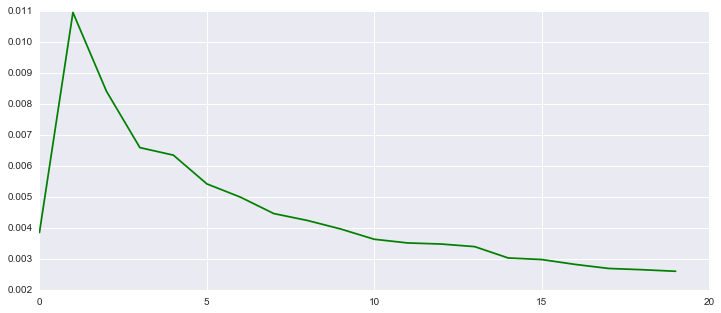

In [36]:
lsa.components_.shape # short and wide matrix
#lsa.components_
#reduced_mat
#pd.DataaFrame(lsa.components_)
# output: 50 rows × 10095 columns
plt.figure(figsize=(12,5))
plt.plot(lsa.explained_variance_ratio_, color='green',marker = '+')#,'r+')

## Explore which documents are similar to which others

In [ ]:
reduced_mat.shape

In [37]:
# might take a while
start = dt.datetime.now()
#print ('test')
sim_mat = np.dot(reduced_mat, reduced_mat.T)

print "the loading took {} seconds ".format((dt.datetime.now()-start).seconds)
#sim_mat.shape
#get_similar_docs(reduced_mat[2535,:],reduced_mat)
#get_similar_docs(reduced_mat[123,:],reduced_mat)

the loading took 1 seconds 


## Test the holdout set
1. use vectorizer tfidf, to 'transform' the holdout set, you don't wanna fit_transform here


In [39]:
#df.article[63][:500]

In [ ]:
# #NOTE: below we just use "transform" not "fit_transform"
# tfidf_vec_test = tfidf.transform(df_test.article)
# reduced_mat_test = lsa.transform(tfidf_vec_test)


# # For the Normalizer, we do a fit_transform, because this is just a division by a constant of each row
# reduced_mat_test = Normalizer(copy=False).fit_transform(reduced_mat_test)

In [51]:
reduced_mat.shape

(6203, 20)

In [ ]:
reduced_mat_test[1]

In [ ]:
len(reduced_mat_test)

In [41]:
''' generate a random article from holdout
    but not from the dataframe, do it from 
     choose the Transformed, Normalized vector matrix:reduce_mat_test '''
def gen_article(df):
    num = np.random.choice(len(df))
    return num, df[num]

In [42]:
## This is a simple convenience function - given one vector representation of a document and 
## the representation of a corpus, return the (indices of) the most similar documents
'''
give me a vector that represetns a single document, give me a corpus (matrix of other do)
'''
def get_similar_docs(target_vec, corpus_vecs, num_res=5):
    sim_scores = np.dot(target_vec, corpus_vecs.T)
    return np.argsort(-sim_scores)[:num_res]

In [ ]:

which_article, choice_reduced_test = gen_article(reduced_mat_test)

In [ ]:
# test similarity (on randomly generated holdout set)

get_similar_docs(choice_reduced_test, reduced_mat)

In [ ]:
df_test.locwhich_article
which_article


In [52]:
''' generate article from holdout AND print out 5 most pertinent articles
    'input' - 
    choice_vec_matrix :: data from which to generate choice article
                                 - can be holdout set
                                 - can be from a particular section of main set
    data_set :: whatever the data is 

'''
def print_recommended(choice_vec_matrix, data_set):
    ## randomly generate article from holdout
    ## get index of DF, and choice_test is the vector matrix
    num_test, choice_test = gen_article(choice_vec_matrix)
    array_five = get_similar_docs(choice_test, reduced_mat)
    #print array_five
    #snip = []
    #title = []
    
    print " num_test, choice+test", num_test
    print " chosen article: ", data_set.iloc[num_test, :]['headline'][:] , "\n"
    #print " array ", array_five
    for a in array_five[1:]:
        #print "a is ", a
        snip =  df.iloc[a,:]['article'][:500] 
        title =  df.iloc[a,:]['headline'][:500] 
        print "\t", title
        print snip , '\n'
   # print "\n".join(title)

In [ ]:
# generate article from holdout set :: test against whole corpu
print_recommended(reduced_mat_test, df_test)

In [ ]:
df.iloc[5830,:]['article'][:500]

In [ ]:
df_test.iloc[which_article,:]['article'][:500]


In [48]:
#gen_multiple(df, 3)

index 	 Title 

5519 	N.F.L. Owners to Weigh Rule Changes
1099 	A Star Who Gave the Mets a Jolt, and Not Just at the Plate 
3331 	New York Today: Respect the Paw


[5519, 1099, 3331]

In [ ]:
# for i in range(5):
#     print("topic {}".format(i))
#     print(get_topical_terms(lsa.components_,i,terms, 35))

In [ ]:
#topics go from 0-50
#get_topical_terms(lsa.components_,num_ix,terms)

''' 
get the index of the max value
'''
topic_ix = reduced_mat[num_ix].argmax(axis=0)
topic_ix# 50x1 .shape
tmp = pd.Series(reduced_mat[num_ix])
tmp.sort_values(ascending=False)[:5]

In [60]:
get_topical_terms(lsa.components_,0,terms, 25)

array([u'trump', u'people', u'clinton', u'music', u'company', u'american',
       u'show', u'state', u'work', u'world', u'president', u'sanders',
       u'states', u'city', u'get', u'may', u'way', u'campaign', u'cruz',
       u'back', u'republican', u'day', u'well', u'made', u'united'], 
      dtype='<U31')

# User input Functions

In [53]:
def gen_article(df):
    num = np.random.choice(len(df))
    return num, df[num]

In [54]:
def gen_multiple(df, how_many):
    num = [np.random.choice(len(df)) for a in range(how_many) ]
    titles = [ df.iloc[a,:]['headline'][:500] for a in num]
    
    print ("index \t Title \n")
    for a in range(len(titles)):
        print num[a], '\t', titles[a]
    return num 

### get topic for doc_vector

In [61]:
terms = np.array(tfidf.get_feature_names())

In [57]:
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [62]:
def get_recommended(data_set, num_ix):
    ''' 
    assumes using reduced_mat vector matrix (and that's ok)
    '''
    
    #num_test, choice_test = gen_article(choice_vec_matrix)
    choice_test = reduced_mat[num_ix]
    
    array_five = get_similar_docs(choice_test, reduced_mat)
    #snip = []
    #title = []

    print " chosen article: ", data_set.iloc[num_ix, :]['headline'][:] , "\n"
   # print array_five #print " array ", array_five
    choice = ['a', 'b', 'c']
    
    for a in array_five[1:]:
        #print "a is ", a
        title =  df.iloc[a,:]['headline'][:500] 
        print a, "\t", title
        #print snip , '\n'
        
    #let's return the terms for this 
    ################# store doc_vector ###############
    # use num_ix to access the DOCUMENT In Tall skinny matrix
    asd = reduced_mat[num_ix,:]
    # 5 most common topics in this document
    topic_list = np.argsort(-asd)[:5]
    names_list = [terms_names[a] for a in topic_list]
    
    return names_list

In [63]:
#for name in terms_names:
 #   tmp_list.count('government')

def interest_dict(l):
    tmp_list = [item for sublist in l for item in sublist]   
    interests = { name : tmp_list.count(name)  for name in terms_names}
    return interests

## user input

In [109]:
user_profile_app()


 
 WHAT DO YOU WANT TO READ? (please input index)
index 	 Title 

921 	Five or Six Things I Didn’t Know About Brad Pitt, by Marlon James
588 	Morning Agenda: Founder of Gawker Suspects Lawsuits Have a Common Financer
6029 	LeBron James Says He’ll Be ‘Much Better’ in Game 3. The Cavs Need Him to Be.
588
 chosen article:  Morning Agenda: Founder of Gawker Suspects Lawsuits Have a Common Financer 

332 	Morning Agenda: Valeant Losses Drag Ackman Hedge Fund Down
5992 	Morning Agenda: The Struggles of Today&#8217;s Sumner Redstone
2672 	Morning Agenda: New Limits on Bankers&#8217; Pay
2533 	Morning Agenda: Alaska Airlines to Buy Virgin America
 
 WHAT DO YOU WANT TO READ? (please input index)
332
 chosen article:  Morning Agenda: Valeant Losses Drag Ackman Hedge Fund Down 

2672 	Morning Agenda: New Limits on Bankers&#8217; Pay
5992 	Morning Agenda: The Struggles of Today&#8217;s Sumner Redstone
2561 	Morning Agenda: Megamergers Face Increasing Challenges in U.S.
2759 	Morning Agenda: Pulte

In [108]:
def user_profile_app():
    doc_vector =[]
    counter=0

    while (counter <3):
        print " \n WHAT DO YOU WANT TO READ? (please input index)"

        if counter == 0: gen_multiple(df, 3)
        num_ix = input()

        topics =  get_recommended(df, num_ix)
        doc_vector.append(topics)

        #print ("your interests are: ", doc_vector)
        counter+=1
        
    interest = interest_dict(doc_vector)
    
    #print interest 
    print '\n', pd.Series(interest).sort_values(ascending=False) , '\n'

In [ ]:
pd.DataFrame(interest, columns = )

In [105]:
{'NYT editorials&comments': 0, 'Museums&Art': 0.1, 'Higher Education': 0, 'Election primaries': 0.4, 
 'Music': 0, 'Election 2016': 0, 'Olympics 2016': 0, 'Democrats News': 0, 'Tech News ': 0, 'Sports': 0,
 'Justice department': 1.0, 'NYC local': 0.2, 'Business&Economy': 0.6, 'Events in NYC': 0, 'University sports': 0, 
 'Politics': 1.0, 'Trends on twitter': 0, 'Education': 1.0, 'Republican News': 0, 'Theater&Broadway': 0.7}




{'Business&Economy': 0.6,
 'Democrats News': 0,
 'Education': 1.0,
 'Election 2016': 0,
 'Election primaries': 0.4,
 'Events in NYC': 0,
 'Higher Education': 0,
 'Justice department': 1.0,
 'Museums&Art': 0.1,
 'Music': 0,
 'NYC local': 0.2,
 'NYT editorials&comments': 0,
 'Olympics 2016': 0,
 'Politics': 1.0,
 'Republican News': 0,
 'Sports': 0,
 'Tech News ': 0,
 'Theater&Broadway': 0.7,
 'Trends on twitter': 0,
 'University sports': 0}

In [ ]:
doc_vector

In [ ]:
#flatten nested list
tmp_list = [item for sublist in doc_vector for item in sublist]

In [67]:
terms_names

NameError: name 'terms_names' is not defined

In [ ]:
np.array(doc_vector)

In [ ]:
len(doc_vector)
doc_vector[1][0]
for i in range(len(doc_vector)):
    for 

In [ ]:
topic_ix = reduced_mat[num_ix].argmax(axis=0)
topic_ix# 50x1 .shape

tmp = pd.Series(reduced_mat[num_ix])
tmp.sort_values(ascending=False)[:3]

get_topical_terms(lsa.components_,i,terms, 35)

In [ ]:
num_ix

In [ ]:
asd = reduced_mat[num_ix,:]
asd

In [ ]:
t = np.argsort(-asd)[:5]

In [ ]:
a = [terms_names[a] for a in t]
a

In [ ]:
terms_names


In [ ]:
tmp = pd.Series(reduced_mat[254,:])
print (tmp.sort_values(ascending=False)[:3])

term_ix = tmp.sort_values(ascending=False)[:3].index

In [ ]:
for a in [0,8,34]:
    print (get_topical_terms(lsa.components_,a,terms, 35))

In [ ]:
a = input()


In [ ]:
a


In [ ]:
# def format_it(txt):
#     """Turns a text document to a list of formatted words.
#     Get rid of possessives, special characters, multiple spaces, etc.
#     """
#     tt = re.sub(r"'s\b", '', txt).lower()  #possessives
#     tt = re.sub(r'[\.\,\;\:\|\'\"\(\)\{\}\$\&\%\*\+\[\]\=\?\!/]', '', tt)  #weird stuff
#     tt = re.sub(r' *\$[0-9]\S* ?', '', tt)  #dollar amounts
#     tt = re.sub(r' *[0-9]\S* ?', '', tt)    
#     tt = re.sub(r'[\-\s]+', ' ', tt)  #hyphen -> space
#     tt = re.sub(r' [a-z] ', ' ', tt)  # single letter -> space
#     return tt.strip()#.split() 

#returns an array  when you split it/ 

In [ ]:
# format_it('000 the}| Article. ; a.q$,' )
## apply format_it to clean text 
# texts [format(doc['article']) for doc in raw
# # df_smaller=pd.DataFrame
# df_smaller['article']= df['article'].apply(lambda x: format_it(x))